In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
from torch.autograd import grad
import time
from typing import Dict, List, Optional, Tuple
import seaborn as sns

In [20]:
class OptionPricingAnalysis:
    def __init__(self, S0: float, K: float, T: float, r: float, sigma: float):
        """
        Initialize the option pricing analysis with base parameters.
        
        Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        T (float): Time to maturity (years)
        r (float): Risk-free interest rate
        sigma (float): Volatility
        """
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        
    def black_scholes_price(self) -> float:
        """Calculate option price using Black-Scholes formula."""
        d1 = self._calculate_d1()
        d2 = self._calculate_d2()
        return self.S0 * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
    
    def _calculate_d1(self) -> float:
        """Helper function to calculate d1 term."""
        return (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
    
    def _calculate_d2(self) -> float:
        """Helper function to calculate d2 term."""
        return self._calculate_d1() - self.sigma * np.sqrt(self.T)
    
    def black_scholes_greeks(self) -> Dict[str, float]:
        """Calculate all Greeks using Black-Scholes formulas."""
        d1 = self._calculate_d1()
        d2 = self._calculate_d2()
        
        # Basic Greeks
        delta = norm.cdf(d1)
        gamma = norm.pdf(d1) / (self.S0 * self.sigma * np.sqrt(self.T))
        theta = (-self.S0 * norm.pdf(d1) * self.sigma / (2 * np.sqrt(self.T)) - 
                self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(d2))
        vega = self.S0 * np.sqrt(self.T) * norm.pdf(d1)
        rho = self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(d2)
        
        # Higher-order Greeks
        charm = -norm.pdf(d1) * (2 * self.r * self.T - d2 * self.sigma * np.sqrt(self.T)) / (2 * self.T * self.sigma * np.sqrt(self.T))
        vanna = -norm.pdf(d1) * d2 / self.sigma
        volga = vega * d1 * d2 / self.sigma
        
        return {
            'delta': delta, 'gamma': gamma, 'theta': theta,
            'vega': vega, 'rho': rho, 'charm': charm,
            'vanna': vanna, 'volga': volga
        }
    
    def monte_carlo_price(self, num_simulations: int) -> Tuple[float, float]:
        """
        Calculate option price using Monte Carlo simulation.
        Returns price and absolute error compared to Black-Scholes.
        """
        # Generate random standard normal variables
        Z = np.random.standard_normal(num_simulations)
        
        # Calculate stock price at maturity
        ST = self.S0 * np.exp((self.r - 0.5 * self.sigma**2) * self.T + 
                            self.sigma * np.sqrt(self.T) * Z)
        
        # Calculate the payoffs
        payoffs = np.maximum(ST - self.K, 0)
        
        # Discount payoffs to present value
        price = np.exp(-self.r * self.T) * np.mean(payoffs)
        
        # Calculate absolute error compared to Black-Scholes
        bs_price = self.black_scholes_price()
        abs_error = abs(price - bs_price)
        
        return price, abs_error
    
    def monte_carlo_greeks_finite_diff(self, num_simulations: int, eps: float = 0.01) -> Dict[str, float]:
        """Calculate Greeks using Monte Carlo with finite differences."""
        base_price = self.monte_carlo_price(num_simulations)[0]
    
        # Store original parameters
        orig_params = {'S0': self.S0, 'sigma': self.sigma, 'r': self.r, 'T': self.T}
    
        greeks = {}
    
        # Delta
        self.S0 += eps
        up_price = self.monte_carlo_price(num_simulations)[0]
        self.S0 = orig_params['S0'] - eps
        down_price = self.monte_carlo_price(num_simulations)[0]
        greeks['delta'] = (up_price - down_price) / (2 * eps)
        self.S0 = orig_params['S0']
    
        # Gamma
        greeks['gamma'] = (up_price - 2 * base_price + down_price) / (eps ** 2)
    
        # Theta
        self.T += eps
        up_price = self.monte_carlo_price(num_simulations)[0]
        greeks['theta'] = -(up_price - base_price) / eps
        self.T = orig_params['T']
    
        # Vega
        self.sigma += eps
        up_price = self.monte_carlo_price(num_simulations)[0]
        self.sigma = orig_params['sigma'] - eps
        down_price = self.monte_carlo_price(num_simulations)[0]
        greeks['vega'] = (up_price - down_price) / (2 * eps)
        self.sigma = orig_params['sigma']
    
        # Rho
        self.r += eps
        up_price = self.monte_carlo_price(num_simulations)[0]
        self.r = orig_params['r'] - eps
        down_price = self.monte_carlo_price(num_simulations)[0]
        greeks['rho'] = (up_price - down_price) / (2 * eps)
        self.r = orig_params['r']
        
        # Higher order Greeks
        # Charm (derivative of delta with respect to time)
        self.T += eps
        self.S0 += eps
        up_t_up_s = self.monte_carlo_price(num_simulations)[0]
        self.S0 = orig_params['S0'] - eps
        up_t_down_s = self.monte_carlo_price(num_simulations)[0]
        self.T = orig_params['T']
        greeks['charm'] = -((up_t_up_s - up_t_down_s) - (up_price - down_price)) / (2 * eps * eps)
        self.S0 = orig_params['S0']
        
        # Vanna (mixed derivative of price with respect to S0 and sigma)
        self.sigma += eps
        self.S0 += eps
        up_s_up_sig = self.monte_carlo_price(num_simulations)[0]
        self.S0 = orig_params['S0'] - eps
        up_s_down_sig = self.monte_carlo_price(num_simulations)[0]
        greeks['vanna'] = (up_s_up_sig - up_s_down_sig) / (4 * eps * eps)
        
        # Volga (second derivative with respect to volatility)
        greeks['volga'] = (up_price - 2 * base_price + down_price) / (eps ** 2)
        
        # Restore original parameters
        self.__dict__.update(orig_params)
        
        return greeks
    
    def monte_carlo_greeks_autodiff(self, num_simulations: int) -> Dict[str, float]:
        """Calculate Greeks using Monte Carlo with automatic differentiation."""
        # Convert inputs to tensors with explicit dtype
        S0_tensor = torch.tensor(self.S0, dtype=torch.float32, requires_grad=True)
        r_tensor = torch.tensor(self.r, dtype=torch.float32, requires_grad=True)
        sigma_tensor = torch.tensor(self.sigma, dtype=torch.float32, requires_grad=True)
        T_tensor = torch.tensor(self.T, dtype=torch.float32, requires_grad=True)
        K_tensor = torch.tensor(self.K, dtype=torch.float32)
    
        # Generate random numbers
        torch.manual_seed(42)
        Z = torch.randn(num_simulations, dtype=torch.float32)
    
        def price_calc():
            ST = S0_tensor * torch.exp((r_tensor - 0.5 * sigma_tensor**2) * T_tensor + 
                                 sigma_tensor * torch.sqrt(T_tensor) * Z)
            payoffs = torch.maximum(ST - K_tensor, torch.tensor(0., dtype=torch.float32))
            return torch.exp(-r_tensor * T_tensor) * torch.mean(payoffs)
    
        # Calculate price and gradients
        price = price_calc()
        greeks = {}
    
        # Delta
        try:
            delta_grad = torch.autograd.grad(price, S0_tensor, retain_graph=True)
            greeks['delta'] = delta_grad[0].item() if delta_grad[0] is not None else 0.0
        except:
            greeks['delta'] = 0.0
    
        # Gamma (second derivative with respect to S0)
        try:
            if greeks['delta'] != 0.0:
                gamma_grad = torch.autograd.grad(delta_grad[0], S0_tensor, retain_graph=True)
                greeks['gamma'] = gamma_grad[0].item() if gamma_grad[0] is not None else 0.0
            else:
                greeks['gamma'] = 0.0
        except:
            greeks['gamma'] = 0.0
    
        # Theta
        try:
            theta_grad = torch.autograd.grad(price, T_tensor, retain_graph=True)
            greeks['theta'] = -theta_grad[0].item() if theta_grad[0] is not None else 0.0
        except:
            greeks['theta'] = 0.0
    
        # Vega
        try:
            vega_grad = torch.autograd.grad(price, sigma_tensor, retain_graph=True)
            greeks['vega'] = vega_grad[0].item() if vega_grad[0] is not None else 0.0
        except:
            greeks['vega'] = 0.0
    
        # Rho
        try:
            rho_grad = torch.autograd.grad(price, r_tensor, retain_graph=True)
            greeks['rho'] = rho_grad[0].item() if rho_grad[0] is not None else 0.0
        except:
            greeks['rho'] = 0.0
    
        # Higher order Greeks
        # Charm (derivative of delta with respect to time)
        try:
            if greeks['delta'] != 0.0:
                charm_grad = torch.autograd.grad(delta_grad[0], T_tensor, retain_graph=True)
                greeks['charm'] = -charm_grad[0].item() if charm_grad[0] is not None else 0.0
            else:
                greeks['charm'] = 0.0
        except:
            greeks['charm'] = 0.0
    
        # Vanna (derivative of delta with respect to volatility)
        try:
            if greeks['delta'] != 0.0:
                vanna_grad = torch.autograd.grad(delta_grad[0], sigma_tensor, retain_graph=True)
                greeks['vanna'] = vanna_grad[0].item() if vanna_grad[0] is not None else 0.0
            else:
                greeks['vanna'] = 0.0
        except:
            greeks['vanna'] = 0.0
    
        # Volga (second derivative with respect to volatility)
        try:
            if greeks['vega'] != 0.0:
                volga_grad = torch.autograd.grad(vega_grad[0], sigma_tensor)
                greeks['volga'] = volga_grad[0].item() if volga_grad[0] is not None else 0.0
            else:
                greeks['volga'] = 0.0
        except:
            greeks['volga'] = 0.0
    
        return greeks
    
    def run_comprehensive_analysis(self, num_simulations_range: List[int]) -> Dict[str, pd.DataFrame]:
        """Run comprehensive analysis comparing all methods."""
        results = {
            'prices': [],
            'greeks': [],
            'performance': []
        }
        
        bs_price = self.black_scholes_price()
        
        # Run analysis for each simulation size
        for n_sim in num_simulations_range:
            start_time = time.time()
            
            # Prices
            mc_price, abs_error = self.monte_carlo_price(n_sim)
            rel_error = abs_error  # Keep absolute error for consistency with original
            
            # Store results
            results['prices'].append({
                'num_sim': n_sim,
                'bs_price': bs_price,
                'mc_price': mc_price,
                'rel_error': rel_error
            })
            
            end_time = time.time()
            results['performance'].append({
                'num_sim': n_sim,
                'computation_time': end_time - start_time
            })
        
        return {k: pd.DataFrame(v) for k, v in results.items()}
    
    def plot_results(self, results: Dict[str, pd.DataFrame]) -> None:
        """Plot comprehensive analysis results including error comparison."""
        plt.figure(figsize=(12, 8))
        
        # Absolute Error vs Expected Error (Original plot)
        simulation_numbers = results['prices']['num_sim']
        actual_errors = results['prices']['rel_error']
        expected_errors = [self.expected_mc_error(n) for n in simulation_numbers]
        
        plt.loglog(simulation_numbers, actual_errors, 'bo-', label='Actual Error')
        plt.loglog(simulation_numbers, expected_errors, 's-', color='orange', label='Expected Error')
        plt.xlabel('Number of Simulations')
        plt.ylabel('Error')
        plt.title('Actual vs Expected Error in Monte Carlo Option Pricing')
        plt.legend()
        plt.grid(True, which="both", ls="-", alpha=0.5)
        plt.tight_layout()

    def expected_mc_error(self, num_simulations: int) -> float:
        """
        Calculate the expected Monte Carlo error.
        Uses the same formula as in the original implementation.
        """
        d1 = self._calculate_d1()
        d2 = self._calculate_d2()
        
        variance = np.exp(-2 * self.r * self.T) * (
            self.S0**2 * np.exp(2 * self.r * self.T) * norm.cdf(d1) * (1 - norm.cdf(d1)) +
            self.K**2 * norm.cdf(d2) * (1 - norm.cdf(d2)) -
            2 * self.S0 * self.K * np.exp(self.r * self.T) * 
            (norm.cdf(d1) * norm.cdf(d2) - norm.cdf(d1) * norm.cdf(d2))
        )
        
        return np.sqrt(variance / num_simulations)
    
    def print_comprehensive_results(self, num_simulations_range: List[int]) -> None:
        """
        Print detailed results including prices and Greeks for each simulation size.
        """
        # Calculate Black-Scholes values once
        bs_price = self.black_scholes_price()
        bs_greeks = self.black_scholes_greeks()
        
        # Print price comparison header
        print("\nOption Price Comparison:")
        print("-" * 100)
        print(f"{'Num Simulations':>15} | {'MC Price':>12} | {'BS Price':>12} | {'Abs Error':>12} | {'Expected Error':>12}")
        print("-" * 100)
        
        for n_sim in num_simulations_range:
            # Calculate Monte Carlo price and errors
            mc_price, abs_error = self.monte_carlo_price(n_sim)
            expected_error = self.expected_mc_error(n_sim)
            
            print(f"{n_sim:>15} | {mc_price:>12.6f} | {bs_price:>12.6f} | {abs_error:>12.6f} | {expected_error:>12.6f}")
        
        # Print Greeks comparison
        print("\nGreeks Comparison:")
        print("-" * 140)
        header = f"{'Num Simulations':>15} |"
        for greek in ['delta', 'gamma', 'theta', 'vega', 'rho']:
            header += f" {greek.capitalize():>12} (MC) | {greek.capitalize():>12} (BS) |"
        print(header)
        print("-" * 140)
        
        for n_sim in num_simulations_range:
            # Calculate Monte Carlo Greeks
            mc_greeks = self.monte_carlo_greeks_finite_diff(n_sim)
            
            row = f"{n_sim:>15} |"
            for greek in ['delta', 'gamma', 'theta', 'vega', 'rho']:
                row += f" {mc_greeks[greek]:>12.6f} | {bs_greeks[greek]:>12.6f} |"
            print(row)
        
        # Print higher-order Greeks
        print("\nHigher-Order Greeks Comparison:")
        print("-" * 140)
        header = f"{'Num Simulations':>15} |"
        for greek in ['charm', 'vanna', 'volga']:
            header += f" {greek.capitalize():>12} (MC) | {greek.capitalize():>12} (BS) |"
        print(header)
        print("-" * 140)
        
        for n_sim in num_simulations_range:
            # Calculate Monte Carlo Greeks
            mc_greeks = self.monte_carlo_greeks_finite_diff(n_sim)
            
            row = f"{n_sim:>15} |"
            for greek in ['charm', 'vanna', 'volga']:
                row += f" {mc_greeks[greek]:>12.6f} | {bs_greeks[greek]:>12.6f} |"
            print(row)

    def print_summary_statistics(self, num_simulations: int) -> None:
        """
        Print summary statistics for a single simulation size.
        """
        print("\nSummary Statistics:")
        print("-" * 50)
        
        # Calculate all values
        bs_price = self.black_scholes_price()
        bs_greeks = self.black_scholes_greeks()
        mc_price, abs_error = self.monte_carlo_price(num_simulations)
        mc_greeks_fd = self.monte_carlo_greeks_finite_diff(num_simulations)
        mc_greeks_ad = self.monte_carlo_greeks_autodiff(num_simulations)
        
        print(f"Number of simulations: {num_simulations:,}")
        print(f"Black-Scholes price: {bs_price:.6f}")
        print(f"Monte Carlo price: {mc_price:.6f}")
        print(f"Absolute Error: {abs_error:.6f}")
        print(f"Expected Error: {self.expected_mc_error(num_simulations):.6f}")
        
        print("\nGreeks Comparison:")
        print("-" * 50)
        print(f"{'Greek':<10} {'Black-Scholes':>15} {'MC (FD)':>15} {'MC (AD)':>15}")
        print("-" * 50)
        
        for greek in bs_greeks.keys():
            print(f"{greek:<10} {bs_greeks[greek]:>15.6f} {mc_greeks_fd[greek]:>15.6f} {mc_greeks_ad[greek]:>15.6f}")

In [21]:
# Initialize the analysis
analysis = OptionPricingAnalysis(S0=100, K=110, T=1, r=0.05, sigma=0.3)

# Print detailed results for all simulation sizes
simulation_numbers = [10**i for i in range(1, 9)]  # [10, 100, 1000, ..., 100000000]
analysis.print_comprehensive_results(simulation_numbers)

# Print detailed summary for a specific simulation size
analysis.print_summary_statistics(100000)


Option Price Comparison:
----------------------------------------------------------------------------------------------------
Num Simulations |     MC Price |     BS Price |    Abs Error | Expected Error
----------------------------------------------------------------------------------------------------
             10 |     9.461493 |    10.020078 |     0.558585 |    22.547490
            100 |    12.088045 |    10.020078 |     2.067967 |     7.130143
           1000 |     9.990831 |    10.020078 |     0.029246 |     2.254749
          10000 |     9.937087 |    10.020078 |     0.082991 |     0.713014
         100000 |     9.960513 |    10.020078 |     0.059564 |     0.225475
        1000000 |    10.038642 |    10.020078 |     0.018565 |     0.071301
       10000000 |    10.026294 |    10.020078 |     0.006216 |     0.022547
      100000000 |    10.019559 |    10.020078 |     0.000519 |     0.007130

Greeks Comparison:
------------------------------------------------------------------

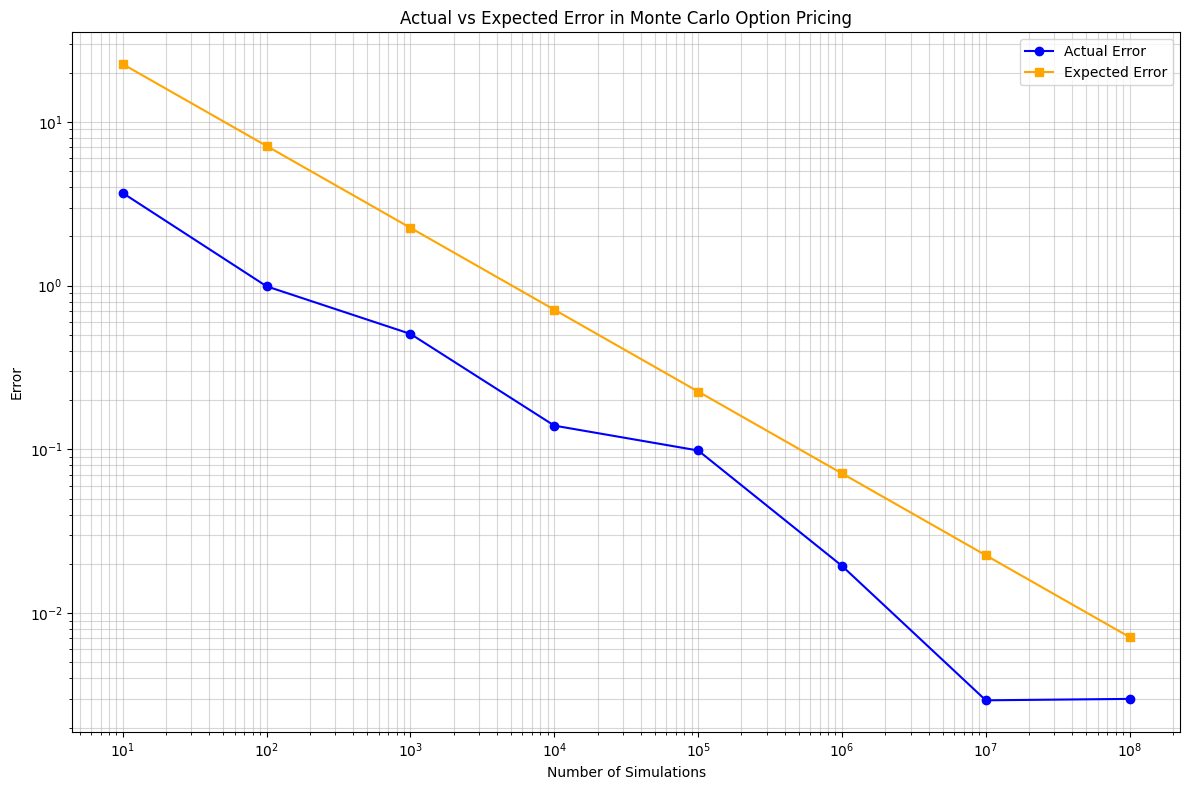

In [23]:
results = analysis.run_comprehensive_analysis(simulation_numbers)

# Generate visualization
analysis.plot_results(results)